In [1]:
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random
from sklearn.preprocessing import normalize

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


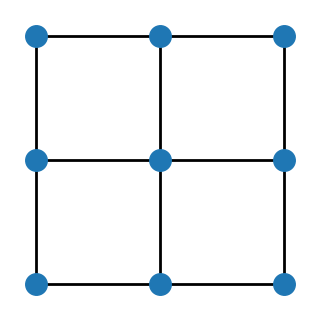

In [3]:
dims = (3, 3)
g = tu.generate_grid_graph(dims, queen=False)

# relabel nodes if you want them as {1, 2, 3,...} instead of {(0,0), (0, 1), ...}
# def reverse_dict(d):
#     new_dict = dict()
#     for k, v in d.items():
#         new_dict[v] = k
#     return new_dict
# labels = {node: (dims[0] * node[0]) + node[1] + 1 for node in g.nodes}
# g = nx.relabel_nodes(g, labels, copy=False)
# node_map = reverse_dict(labels)
# tu.draw(g, node_map=node_map)

tu.draw(g)

In [5]:
def wilsons(g):
    root = randomly_pick_root(g)
    
    tree = nx.Graph()
    tree.add_node(root)
    
    while tree.number_of_nodes() < g.number_of_nodes():
        add_branch(g, tree)
        
    return tree

def randomly_pick_root(g):
    return random.choice(list(g.nodes))

def sort_edge(edge):
    return tuple(sorted([tuple(sorted(edge[0])), tuple(sorted(edge[1]))]))

def pick_leaf(g, tree):
    candidates = list(set(g.nodes()) - set(tree.nodes()))
    return random.choice(candidates)

def erase_singletons(branch):
    # remove the singletons after erasing the loop
    to_remove = []
    for node in branch.nodes:
        if len(list(branch.neighbors(node))) == 0:
            to_remove.append(node)
    for node in to_remove:
        branch.remove_node(node)
            
def erase_loop_if_exists(branch, g):
    """ dont need to pass g TODO
    """
    try:
        cycle = nx.find_cycle(branch)
        
        for (u, v) in cycle:
            branch.remove_edge(u, v)
        erase_singletons(branch)
        
    except nx.exception.NetworkXNoCycle:
        pass

def loop_exists(g):
    """ Returns True if cycle exists in graph g.
    """
    try:
        cycle = nx.find_cycle(g)
        return True
    except nx.exception.NetworkXNoCycle:
        return False

def add_branch(g, tree):
    leaf = pick_leaf(g, tree)
    curr = leaf
    branch = nx.Graph()
    reached_root = False
    
    while reached_root is False:
        nxt = random.choice(list(g.neighbors(curr)))
        
        # handle the case of small two edge cycles
        if branch.has_edge(curr, nxt):
            branch.remove_edge(curr, nxt)
            erase_singletons(branch)
            curr = nxt
            continue
            
        
        branch.add_edge(curr, nxt)
        erase_loop_if_exists(branch, g)
        curr = nxt

        if nxt in tree.nodes():
            reached_root = True
            
    tree = tree.update(branch.edges, branch.nodes)

In [6]:
def test_valid_tree(tree, g):
    assert(len(list(nx.connected_components(tree))) == 1)
    assert(len(tree.edges) == len(g.nodes)-1)

for i in range(1000):
    tree = wilsons(g)
    test_valid_tree(tree, g)

In [7]:
all_trees = [tu.tup(tree) for tree in tu.enumerate_all_trees(g)]

192it [00:00, 2457.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3228.40it/s]


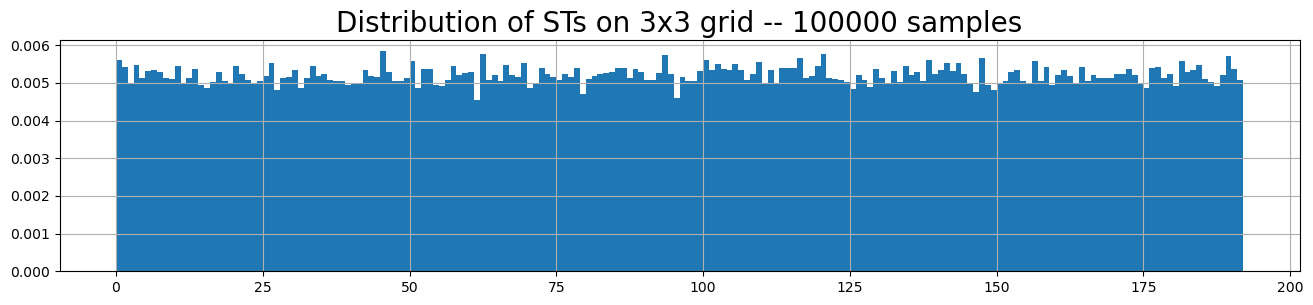

In [8]:
num_trials = 100000
data = []

for _ in tqdm(range(num_trials)):
    tree = wilsons(g)

    idx = all_trees.index(tu.tup(tree))
    data.append(idx)
    
tu.plot_sampled_STs(all_trees, data)

100%|███████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:01<00:00, 1630.56it/s]


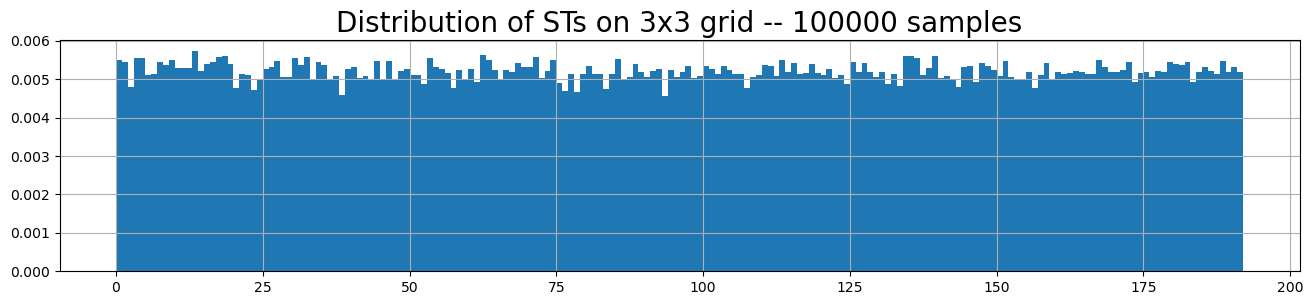

In [9]:
# comparison with the spanning tree function already in tree_utils
data = tu.sample_STs(all_trees, "UST", num_trials)
tu.plot_sampled_STs(all_trees, data)